# Motivation and description of results:
The wikimedia detox datasets are a crowdsourced collection of datasets where reviewers evaluated wikipedia discussion comments for aggression, toxicity and whether the comments should be considered an attack. In this notebook we explore some of the properties of the aggression and toxicity datasets from the wikimedia detox dataset collections, as well as some of the relationships between the two, with the purpose of identifying biases in the data. 

Specifically, we look at the distribution of reviewer's genders and age groups. We further analyze how reviews differed across these different gender and age groups. The reason for looking at the group disparities in comment scores is to determine how the data is biased by a dearth of representation from some of these groups.

Additionally, we take advantage of US census data to get an idea of how the demographics of the reviewers compares to the population at large. With respect to this comparison it should be mentioned that it is itself an approximate comparison, since 1) not all reviewers need be members of the US population, 2) not all reviewers elected to report their demographics, and those that elected to report may not be representative of the group that did, and 3) the census data is itself an estimate of the population. This information is used to understand how the distribution of reviewer age groups differs from the US population. This is used in conjunction with analysis of disparities in scoring across groups to estimate a direction of bias in scoring compared to what would be expected from a random sample of the US population.

Finally, we examine how evaluations of toxicity and aggression change based on what year the comment was from. This is done to determine how stable the scores for comments over time. 

## Results
In comparing the age distribution of toxicity and aggression reviewers to the census age distribution we see that the reviewers in this study were much younger than the population, being heavily skewed towards the age range 18-30 and less so but still significantly towards the range 30-45. 

In comparing the age distributions for female and male reviewers we find that females are much more likely to be 45 and older than the males were, whereas the males are more likely to be younger than 45 than the females. However, the 18-45 range still accounted for the overwhelming majority for both genders.

We then go on to note that the reviewer set is heavily male skewed, with males accounting for 61.62% of the aggression reviewers and 64.81% of the toxicity reviewers. Looking at the distribution of actual reviews, the toxicity review set contained 66% males and the aggression review set was 63.98. % male. The difference in gender distributions for the review set and the reviewer set was due to the fact that reviewers differed in the number of reviews they performed, with males on average reviewing more. 

When we increase the weight of the females scores by counting each female review twice we see what we'd expect: For reasonable threshold values for high toxicity and high aggressiveness, we find more highly toxic and highly aggressive comments.  

Also we note an interesting trend where comments reviewed for both toxicity and aggression are rated lower on those dimensions than those that were only reviewed for one of the two.

In comparing the two datasets, we've found that reviewers on average were more inclined to rate a review as aggressive as they were to rate it toxic, with comments tending to have a slightly negative average rating in terms of aggression and a slightly positive score with respect to toxicity (with negative scores corresponding to more aggressive or toxic comments).

From the beginning of the comment sample window to the mid naughts both aggression and toxicity increased. They then remained largely stable for the remainder of time frame.

# Analysis
We begin as usual with our imports:

In [187]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from os import path

sns.set()

Now let's declare some constants and save the wikimedia datasets locally.

In [193]:
#urls and files
AGGRESSION_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7038038'
AGGRESSION_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7394506'
AGGRESSION_WORKER_DEMOGRAPHIC_URL = 'https://ndownloader.figshare.com/files/7640644'

TOXIC_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7394542' 
TOXIC_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7394539' 
TOXIC_WORKER_DEMOGRAPHIC_URL = 'https://ndownloader.figshare.com/files/7640581'

CENSUS_URL = 'https://www2.census.gov/programs-surveys/popest/' + \
    'technical-documentation/file-layouts/2010-2019/nc-est2019-agesex-res.csv'
AGGRESSION_ANNOTATED_COMMENTS_TSV = 'AGGRESSION_ANNOTATED_COMMENTS.tsv'
AGGRESSION_ANNOTATIONS_TSV = 'AGGRESSION_ANNOTATIONS.tsv'
AGGRESSION_WORKER_DEMOGRAPHIC_TSV = 'AGGRESSION_WORKER_DEMOGRAPHIC.tsv'

TOXIC_ANNOTATED_COMMENTS_TSV = 'TOXIC_ANNOTATED_COMMENTS.tsv' 
TOXIC_ANNOTATIONS_TSV = 'TOXIC_ANNOTATIONS.tsv' 
TOXIC_WORKER_DEMOGRAPHIC_TSV = 'TOXIC_WORKER_DEMOGRAPHIC.tsv'
CENSUS_CSV = 'GENDER_AGE.CSV'

url_file_map = {
    AGGRESSION_ANNOTATED_COMMENTS_URL : AGGRESSION_ANNOTATED_COMMENTS_TSV, \
    AGGRESSION_ANNOTATIONS_URL : AGGRESSION_ANNOTATIONS_TSV, \
    AGGRESSION_WORKER_DEMOGRAPHIC_URL : AGGRESSION_WORKER_DEMOGRAPHIC_TSV, \
    TOXIC_ANNOTATED_COMMENTS_URL : TOXIC_ANNOTATED_COMMENTS_TSV, \
    TOXIC_ANNOTATIONS_URL : TOXIC_ANNOTATIONS_TSV, \
    TOXIC_WORKER_DEMOGRAPHIC_URL : TOXIC_WORKER_DEMOGRAPHIC_TSV, \
    CENSUS_URL : CENSUS_CSV };

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

for url in url_file_map:
    if not path.exists(url_file_map[url]):
        download_file(url, url_file_map[url])    

Now lets load our datasets into memory and do some cleanup on the data:

In [194]:
# read the files into memory
toxicity_comments = pd.read_csv(TOXIC_ANNOTATED_COMMENTS_TSV, sep = '\t', index_col = 0)
toxicity_annotations = pd.read_csv(TOXIC_ANNOTATIONS_TSV,  sep = '\t')
toxicity_worker_demographic = pd.read_csv(TOXIC_WORKER_DEMOGRAPHIC_TSV,  sep = '\t', index_col = None)
aggression_comments = pd.read_csv(AGGRESSION_ANNOTATED_COMMENTS_TSV, sep = '\t', index_col = 0)
aggression_annotations = pd.read_csv(AGGRESSION_ANNOTATIONS_TSV,  sep = '\t')
aggression_worker_demographic = pd.read_csv(AGGRESSION_WORKER_DEMOGRAPHIC_TSV,  sep = '\t', index_col = None)

# cleanup the comments
toxicity_comments['comment'] = toxicity_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
aggression_comments['comment'] = aggression_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

# both toxicity_worker_demographic and aggression_worker_demographic have a single row with gender == 'other'
# since there is only a single instance in each, we can't do much in the way of comparative analysis for this category
# so just dropping
toxicity_worker_demographic = toxicity_worker_demographic[toxicity_worker_demographic.gender != 'other']
aggression_worker_demographic = aggression_worker_demographic[aggression_worker_demographic.gender != 'other']

Now lets stitch data from the files into toxic and aggression join tables. The resulting dataframe will represent an instance of a reviewer's comment review.

In [195]:
# add cols for avg toxicity and aggression
toxicity_scores = toxicity_annotations.groupby('rev_id')['toxicity_score'].mean().rename('avg_toxicity_score')
aggression_scores = aggression_annotations.groupby('rev_id')['aggression_score'].mean().rename('avg_aggression_score')

# create our toxicity and aggression join tables
toxicity_join = toxicity_comments.merge(
    toxicity_scores, on='rev_id', how="inner").merge(
    toxicity_annotations, on='rev_id', how="inner").merge(
    toxicity_worker_demographic, on='worker_id', how="inner")
aggression_join = aggression_comments.merge(
    aggression_scores, on='rev_id', how="inner").merge(
    aggression_annotations, on='rev_id', how="inner").merge(
    aggression_worker_demographic, on='worker_id', how="inner")

# let's also stick the number of reviews the reviewer made total on to each row since it may come in handy later
toxicity_reviewer_groups = toxicity_join.groupby('worker_id')
toxicity_reviewer_review_counts = toxicity_reviewer_groups['rev_id'].count().rename('reviewer_count')
toxicity_join = toxicity_join.merge(toxicity_reviewer_review_counts, on='worker_id')

aggression_reviewer_groups = aggression_join.groupby('worker_id')
aggression_reviewer_review_counts = aggression_reviewer_groups['rev_id'].count().rename('reviewer_count')
aggression_join = aggression_join.merge(aggression_reviewer_review_counts, on='worker_id')


Now let's get the breakdown of reviewer by age, both for males and females and for toxicity and aggression:

In [196]:
female_toxicity_worker_demographic = toxicity_worker_demographic[toxicity_worker_demographic.gender == 'female']
female_toxicity_reviewers_who_reported_their_age = female_toxicity_worker_demographic[['worker_id','age_group']].dropna()
count_female_toxicity_reviewers_who_reported_their_age = female_toxicity_reviewers_who_reported_their_age['worker_id'].count()
female_toxicity_reviewer_gender_age_groups = female_toxicity_worker_demographic.groupby(['age_group'])

female_toxicity_reviewer_age_group_percentage_dict = \
    ({key: 100 * len(val)/count_female_toxicity_reviewers_who_reported_their_age for key, val in \
      female_toxicity_reviewer_gender_age_groups['worker_id']})

male_toxicity_worker_demographic = toxicity_worker_demographic[toxicity_worker_demographic.gender == 'male']
male_toxicity_reviewers_who_reported_their_age = male_toxicity_worker_demographic[['worker_id','age_group']].dropna()
count_male_toxicity_reviewers_who_reported_their_age = male_toxicity_reviewers_who_reported_their_age['worker_id'].count()
male_toxicity_reviewer_gender_age_groups = male_toxicity_worker_demographic.groupby(['age_group'])

male_toxicity_reviewer_age_group_percentage_dict = \
    ({key: 100 * len(val)/count_male_toxicity_reviewers_who_reported_their_age for key, val in \
      male_toxicity_reviewer_gender_age_groups['worker_id']})

female_aggression_worker_demographic = aggression_worker_demographic[aggression_worker_demographic.gender == 'female']
female_aggression_reviewers_who_reported_their_age = female_aggression_worker_demographic[['worker_id','age_group']].dropna()
count_female_aggression_reviewers_who_reported_their_age = female_aggression_reviewers_who_reported_their_age['worker_id'].count()
female_aggression_reviewer_gender_age_groups = female_aggression_worker_demographic.groupby(['age_group'])

female_aggression_reviewer_age_group_percentage_dict = \
    ({key: 100 * len(val)/count_female_aggression_reviewers_who_reported_their_age for key, val in \
      female_aggression_reviewer_gender_age_groups['worker_id']})

male_aggression_worker_demographic = aggression_worker_demographic[aggression_worker_demographic.gender == 'male']
male_aggression_reviewers_who_reported_their_age = male_aggression_worker_demographic[['worker_id','age_group']].dropna()
count_male_aggression_reviewers_who_reported_their_age = male_aggression_reviewers_who_reported_their_age['worker_id'].count()
male_aggression_reviewer_gender_age_groups = male_aggression_worker_demographic.groupby(['age_group'])

male_aggression_reviewer_age_group_percentage_dict = \
    ({key: 100 * len(val)/count_male_aggression_reviewers_who_reported_their_age for key, val in \
      male_aggression_reviewer_gender_age_groups['worker_id']})

Now let's load the census data into memory and process it so that we can compare the age distribution in US to the reviewers: 

In [197]:
# load census data
american_gender_age_df = pd.DataFrame(pd.read_csv(CENSUS_CSV, sep = ',', header = 0)[['SEX','AGE','POPESTIMATE2016']])
american_gender_age_df = american_gender_age_df[american_gender_age_df.AGE != 999]
female_age_df = american_gender_age_df[american_gender_age_df['SEX'] == 2]
male_age_df = american_gender_age_df[american_gender_age_df['SEX'] == 1]
total_females_in_population = female_age_df.POPESTIMATE2016.sum()
total_males_in_population = male_age_df.POPESTIMATE2016.sum()
american_female_age_groups = female_age_df.groupby('AGE')['POPESTIMATE2016'].apply(lambda x: x/total_females_in_population) 
american_male_age_groups = male_age_df.groupby('AGE')['POPESTIMATE2016'].apply(lambda x: x/total_males_in_population)

american_female_under_18_percentage = 100 * sum(list(american_female_age_groups)[0:18])
american_female_18_to_30_percentage = 100 * sum(list(american_female_age_groups)[18:30])
american_female_30_to_45_percentage = 100 * sum(list(american_female_age_groups)[30:45])
american_female_45_to_60_percentage = 100 * sum(list(american_female_age_groups)[45:60])
american_female_over_60_percentage = 100 * sum(list(american_female_age_groups)[60:102])

american_male_under_18_percentage = 100 * sum(list(american_male_age_groups)[0:18])
american_male_18_to_30_percentage = 100 * sum(list(american_male_age_groups)[18:30])
american_male_30_to_45_percentage = 100 * sum(list(american_male_age_groups)[30:45])
american_male_45_to_60_percentage = 100 * sum(list(american_male_age_groups)[45:60])
american_male_over_60_percentage = 100 * sum(list(american_male_age_groups)[60:102])

male_percentages = {'Under 18':american_male_under_18_percentage, \
                '18-30':american_male_18_to_30_percentage, \
                '30-45':american_male_30_to_45_percentage, \
                '45-60':american_male_45_to_60_percentage, \
                'Over 60':american_male_over_60_percentage}
female_percentages = {'Under 18':american_female_under_18_percentage, \
                "18-30":american_female_18_to_30_percentage, \
                '30-45':american_female_30_to_45_percentage, \
                '45-60':american_female_45_to_60_percentage, \
                'Over 60':american_female_over_60_percentage}


First let's look at how the age distribution for both male and female toxicity reviewers differs from that of the US population at the time of the review: 

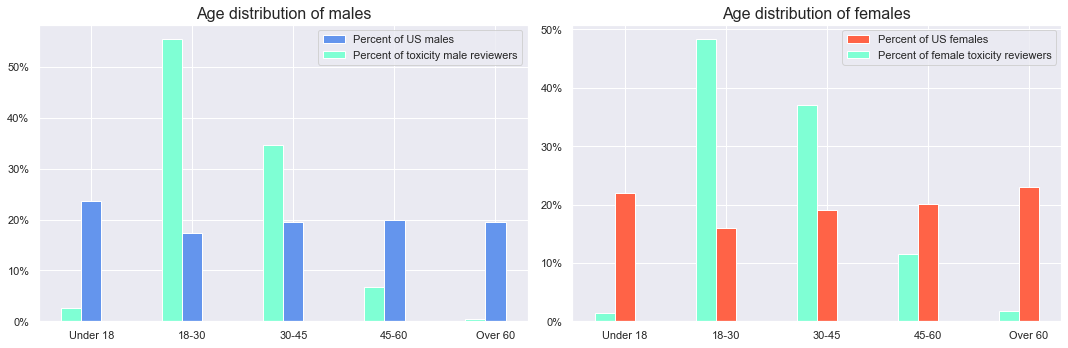

In [198]:
age_ranges = male_percentages.keys()
xcoords = np.arange(len(age_ranges))

ax = plt.subplot(1, 2, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.bar(xcoords, [male_percentages[key] for key in age_ranges], width=0.2, color='cornflowerblue', align='center')
male_toxicity_age_group_percentages = [male_toxicity_reviewer_age_group_percentage_dict[key] for key in age_ranges]
ax.bar(xcoords-0.2, male_toxicity_age_group_percentages, width=0.2, color='aquamarine', align='center')
ax.legend(('Percent of US males','Percent of toxicity male reviewers'))
plt.title("Age distribution of males", fontsize=16)
plt.xticks(xcoords, age_ranges)

ax = plt.subplot(1, 2, 2)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.bar(xcoords, [female_percentages[key] for key in age_ranges], width=0.2, color='tomato', align='center')
female_toxicity_age_group_percentages = [female_toxicity_reviewer_age_group_percentage_dict[key] for key in age_ranges]
ax.bar(xcoords-0.2,  female_toxicity_age_group_percentages, width=0.2, color='aquamarine', align='center')
ax.legend(('Percent of US females','Percent of female toxicity reviewers'))
plt.title("Age distribution of females", fontsize=16)
ax.figure.set_size_inches(15,5)
plt.xticks(xcoords, age_ranges)
plt.tight_layout()
plt.savefig("Age_distribution_of_toxicity_reviewers_by_gender.png")
plt.show()  

Now let's look at the same thing for both female and male aggression reviewers:

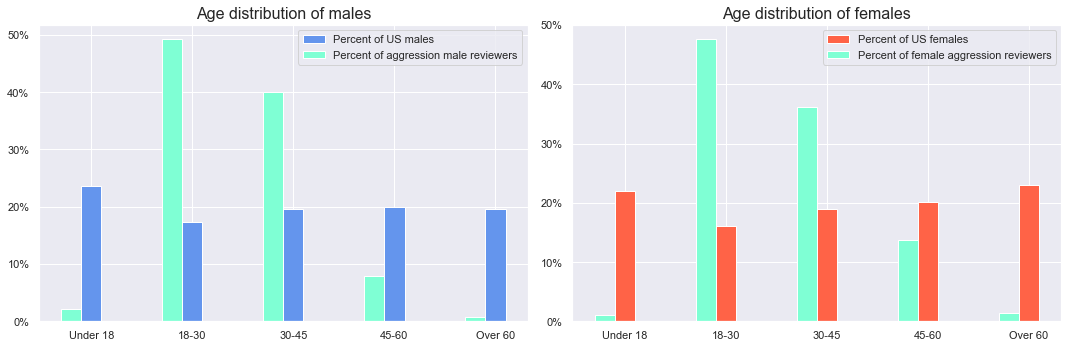

In [199]:
age_ranges = male_percentages.keys()
xcoords = np.arange(len(age_ranges))

ax = plt.subplot(1, 2, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.bar(xcoords, [male_percentages[key] for key in age_ranges], width=0.2, color='cornflowerblue', align='center')
male_aggression_age_group_percentages = [male_aggression_reviewer_age_group_percentage_dict[key] for key in age_ranges]
ax.bar(xcoords-0.2, male_aggression_age_group_percentages, width=0.2, color='aquamarine', align='center')
ax.legend(('Percent of US males','Percent of aggression male reviewers'))
plt.title("Age distribution of males", fontsize=16)
plt.xticks(xcoords, age_ranges)

ax = plt.subplot(1, 2, 2)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.bar(xcoords, [female_percentages[key] for key in age_ranges], width=0.2, color='tomato', align='center')
female_aggression_age_group_percentages = [female_aggression_reviewer_age_group_percentage_dict[key] for key in age_ranges]
ax.bar(xcoords-0.2,  female_aggression_age_group_percentages, width=0.2, color='aquamarine', align='center')
ax.legend(('Percent of US females','Percent of female aggression reviewers'))
plt.title("Age distribution of females", fontsize=16)
ax.figure.set_size_inches(15,5)
plt.xticks(xcoords, age_ranges)
plt.tight_layout()
plt.savefig("Age_distribution_of_aggresion_reviewers_by_gender.png")
plt.show()  

There are significant differences between the age distribution in the US census estimate versus the review sample. The reviewers are about 2.5 times as likely to be in the 18-30 cohort and 2 times as likely to be in the 30-45 cohort then a randomly sample from the census distribution. 

There don't seem to be significant differences between the age breakdown of the reviewers who reviewed comments for toxicity and those who reviewed them for aggression. Comparing the male reviewers to the females we can see that female reviewers were more likely to be in the age groups from 45+, while the males were more likely to be in each of the youngest cohorts. 

Let's check the gender distribution for the reviewers and their respective review counts:

In [200]:
male_toxicity_reviewer_count = len(toxicity_worker_demographic[toxicity_worker_demographic.gender == 'male'])
female_toxicity_reviewer_count = len(toxicity_worker_demographic[toxicity_worker_demographic.gender == 'female'])
male_aggression_reviewer_count = len(aggression_worker_demographic[aggression_worker_demographic.gender == 'male'])
female_aggression_reviewer_count = len(aggression_worker_demographic[aggression_worker_demographic.gender == 'female'])
print("Toxicity review worker gender distribution:")
print("male:\t" + str(male_toxicity_reviewer_count))
print("female:\t" + str(female_toxicity_reviewer_count))
print("\nAggression review worker gender distribution:")
print("male:\t" + str(male_aggression_reviewer_count))
print("female:\t" + str(female_aggression_reviewer_count))

male_toxicity_review_count = len(toxicity_join[toxicity_join.gender == 'male'])
female_toxicity_review_count = len(toxicity_join[toxicity_join.gender == 'female'])
male_aggression_review_count = len(aggression_join[aggression_join.gender == 'male'])
female_aggression_review_count = len(aggression_join[aggression_join.gender == 'female'])

print("\nToxicity review counts by gender:")
print("male:\t" + str(male_toxicity_review_count))
print("female:\t" + str(female_toxicity_review_count))
print("\nAggression review counts by gender:")
print("male:\t" + str(male_aggression_review_count))
print("female:\t" + str(female_aggression_review_count))

# now print 
print("\nAverage toxicity reviews per reviewer by gender:")
print("male:\t" + str(male_toxicity_review_count/male_toxicity_reviewer_count))
print("female:\t" + str(female_toxicity_review_count/female_toxicity_reviewer_count))
print("\nA\Average aggression reviews per reviewer by gender:")
print("male:\t" + str(male_aggression_review_count/male_aggression_reviewer_count))
print("female:\t" + str(female_aggression_review_count/female_aggression_reviewer_count))

Toxicity review worker gender distribution:
male:	2327
female:	1263

Aggression review worker gender distribution:
male:	1349
female:	840

Toxicity review counts by gender:
male:	889251
female:	457346

Aggression review counts by gender:
male:	547328
female:	308103

Average toxicity reviews per reviewer by gender:
male:	382.14482165878815
female:	362.110847189232

A\Average aggression reviews per reviewer by gender:
male:	405.72868791697556
female:	366.7892857142857


Let's put the review breakdowns into some pie charts:

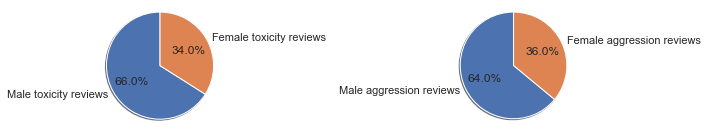

In [201]:
labels = 'Male toxicity reviews', 'Female toxicity reviews'
sizes = [male_toxicity_review_count, female_toxicity_review_count]
ax = plt.subplot(1, 2, 1)
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')

labels = 'Male aggression reviews', 'Female aggression reviews'
sizes = [male_aggression_review_count, female_aggression_review_count]
ax = plt.subplot(1, 2, 2)
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')
fig = plt.gcf()
fig.set_size_inches(10,2)
plt.tight_layout()
plt.savefig("Gender_breakdown_for_toxicity_and_aggression_reviews.png")
plt.show()

Almost twice as many reviews from men as from women and the average male reviewer reviewed 20 more comments for toxicity and 40 more comments for aggression than the average female reviewer did. 

This means our datasets have the following biases: 1) more men reviewed the comments than did women and 2) the men who reviewed the comments reviewed more comments than the women did on average, meaning we would still expect bias even if the study used the same number of reviewers from each gender. 

This could be an issue if there are differences between how men and women are expected to review the comments. Let's check if they have different average ratings for toxicity and aggression:

In [202]:
print("Average toxicity score by gender: " + str(toxicity_join.groupby('gender')['toxicity_score'].mean()))
print("Average aggression score by gender: " + str(aggression_join.groupby('gender')['aggression_score'].mean()))      

Average toxicity score by gender: gender
female    0.178768
male      0.226826
Name: toxicity_score, dtype: float64
Average aggression score by gender: gender
female   -0.232734
male     -0.163730
Name: aggression_score, dtype: float64


So female reviewers on average score reviews as more toxic and aggressive then the males in this sample. This certainly could pose issues for end customers of this dataset. For example, in the case of a binary comment aggression or comment toxicity classifier, for some or maybe all thresholds we'd set for the classifier, we may be excluding comments that would have been considered such had we had a sample more representative of the population. Quite possibly, there would also be comments that would be considered

It also looks as though the reviewers had a higher bar to rate comments as toxic than to rate them as aggressive. Let's take a quick aside to verify this trend on the subset of comments that are in both tables:

In [203]:
reviewed_for_both = set(toxicity_join['rev_id']).intersection(set(aggression_join['rev_id']))
print("Average toxicity score for comments reviewed for aggression and toxicity: "
      + str(toxicity_join[toxicity_join['rev_id'].isin(reviewed_for_both)]['toxicity_score'].mean()))
print("Average aggression score for comments reviewed for aggression and toxicity: " 
      + str(aggression_join[aggression_join['rev_id'].isin(reviewed_for_both)]['aggression_score'].mean()))
print("Average toxicity score for comments reviewed for only toxicity: "
      + str(toxicity_join[~toxicity_join['rev_id'].isin(reviewed_for_both)]['toxicity_score'].mean()))
print("Average aggression score for comments reviewed for only aggression: " 
      + str(aggression_join[~aggression_join['rev_id'].isin(reviewed_for_both)]['aggression_score'].mean()))

Average toxicity score for comments reviewed for aggression and toxicity: 0.032893097811886665
Average aggression score for comments reviewed for aggression and toxicity: -0.3400655231516965
Average toxicity score for comments reviewed for only toxicity: 0.38036619967950624
Average aggression score for comments reviewed for only aggression: 0.07962973759044417


This is in the direction of the expected effect, but now we have a new thread to pursue. The average scores for comments reviewed for both toxicity and aggression were considerably lower for both dimensions if they were reviewed for both. This suggests there may have been some property of the experiment which produced an effect whereby the comments reviewed for both toxicity and for aggression were (either due to the nature of their reviewers or to the nature of the particular set of comments that were reviewed for both,) reviewed to be both more toxic and more aggressive than the average reviewer would find the average comment. This could mean that reviewers who happened to review more comments on average found comments more aggressive and toxic, or that the comments which were reviewed more frequently were the ones that were perceived to be more aggressive/toxic. 

In [204]:
median_toxicity_reviewer_average_number_of_reviews = toxicity_reviewer_groups['rev_id'].count().median()
less_than_median_number_of_toxicity_reviews = toxicity_join[toxicity_join.reviewer_count < median_toxicity_reviewer_average_number_of_reviews]
less_than_median_average_toxicity = less_than_median_number_of_toxicity_reviews['toxicity_score'].mean()
greater_than_median_number_of_toxicity_reviews = toxicity_join[toxicity_join.reviewer_count >= median_toxicity_reviewer_average_number_of_reviews]
greater_than_median_average_toxicity = greater_than_median_number_of_toxicity_reviews['toxicity_score'].mean()
print("Average toxicity score for reviewers who reviewed less than the median review count: " +
     str(less_than_median_average_toxicity))
print("Average toxicity score for reviewers who reviewed greater than the median review count: " +
     str(greater_than_median_average_toxicity))

median_aggression_reviewer_average_number_of_reviews = aggression_reviewer_groups['rev_id'].count().median()
less_than_median_number_of_aggression_reviews = aggression_join[aggression_join.reviewer_count < median_aggression_reviewer_average_number_of_reviews]
less_than_median_average_aggression = less_than_median_number_of_aggression_reviews['aggression_score'].mean()
greater_than_median_number_of_aggression_reviews = aggression_join[aggression_join.reviewer_count >= median_aggression_reviewer_average_number_of_reviews]
greater_than_median_average_aggression = greater_than_median_number_of_aggression_reviews['aggression_score'].mean()
print("Average aggression score for reviewers who reviewed less than the median review count: " +
     str(less_than_median_average_aggression))
print("Average aggression score for reviewers who reviewed greater than the median review count: " +
     str(greater_than_median_average_aggression))

Average toxicity score for reviewers who reviewed less than the median review count: 0.209945652373082
Average toxicity score for reviewers who reviewed greater than the median review count: 0.21088442169642044
Average aggression score for reviewers who reviewed less than the median review count: -0.1607479797519747
Average aggression score for reviewers who reviewed greater than the median review count: -0.19467977319138083


It looks like there isn't a huge difference in how the reviewers who reviewed more comments scored the comments and so we don't have evidence for the hypothesis that reviewers who happened to review more comments on average found comments more aggressive and toxic.

Now let's revisit the gender disparity of the reviewers. Since the toxicity and aggression seem to be sensitive to how many females are in the reviewer set, let's see what happens if we double the number of reviews by females by counting each of their reviews twice. This is the simplest way I can think to simulate a more even gender distribution. Let's then set some threshold values for what we consider very aggressive and very toxic to see how the numbers change in the new distribution versus the distribution from the experiment:

In [205]:
VERY_TOXIC_THRESHOLD = -1
VERY_AGGRESSIVE_THRESHOLD = -1.5

toxic_rev_ids = set((toxicity_join[toxicity_join.avg_toxicity_score < VERY_TOXIC_THRESHOLD]).rev_id)
aggressive_rev_ids = set((aggression_join[aggression_join.avg_aggression_score < VERY_AGGRESSIVE_THRESHOLD]).rev_id)

female_balanced_toxicity_join = pd.concat([toxicity_join, toxicity_join[toxicity_join.gender == 'female']])
female_balanced_aggression_join = pd.concat([aggression_join, aggression_join[aggression_join.gender == 'female']])

female_balanced_toxicity_scores = female_balanced_toxicity_join.groupby('rev_id')['toxicity_score'].mean().rename('updated_avg_toxicity_score')
female_balanced_aggression_scores = female_balanced_aggression_join.groupby('rev_id')['aggression_score'].mean().rename('updated_avg_aggression_score')

female_balanced_toxicity_join = female_balanced_toxicity_join.merge(
    female_balanced_toxicity_scores, on='rev_id', how="inner")

female_balanced_aggression_join = female_balanced_aggression_join.merge(
    female_balanced_aggression_scores, on='rev_id', how="inner")

female_balanced_toxic_rev_ids = set((female_balanced_toxicity_join[female_balanced_toxicity_join.updated_avg_toxicity_score < VERY_TOXIC_THRESHOLD]).rev_id)
female_balanced_aggressive_rev_ids = set((female_balanced_aggression_join[female_balanced_aggression_join.updated_avg_aggression_score < VERY_AGGRESSIVE_THRESHOLD]).rev_id)

toxic_only_in_female_balanced = female_balanced_toxic_rev_ids.difference(toxic_rev_ids)
toxic_only_when_not_female_balanced = toxic_rev_ids.difference(female_balanced_toxic_rev_ids)
aggressive_only_in_female_balanced = female_balanced_aggressive_rev_ids.difference(aggressive_rev_ids)

print("Number of reviews evaluated as very toxic: " + str(len(toxic_rev_ids)))
print("Number of reviews evaluated as very toxic with increased female representation: "
      + str(len(female_balanced_toxic_rev_ids)))
print("Number of reviews evaluated as very aggressive: " + str(len(aggressive_rev_ids)))
print("Number of reviews evaluated as very aggressive with increased female representation: "
      + str(len(female_balanced_aggressive_rev_ids)))


Number of reviews evaluated as very toxic: 6837
Number of reviews evaluated as very toxic with increased female representation: 7217
Number of reviews evaluated as very aggressive: 7688
Number of reviews evaluated as very aggressive with increased female representation: 8122


As we would expect, we see more comments being perceived as high toxicity or high aggression when we include more females in the analysis. It is an interesting question as to what are the salient characteristics of the reviews that didn't make it past the threshold with the experiment's reviewers but did when we increase female review contribution. To explore this I created some wordclouds to compare these comments to those labeled highly toxic by the experimental figures. Both wordclouds were vile and didn't contain any obvious or interesting difference to their vileness so they have not been reproduced here.

Finally, let's take a look at how the reviews change based on which year the comment came from. We'll start by looking at the average score over time for both aggression and toxicity over time:

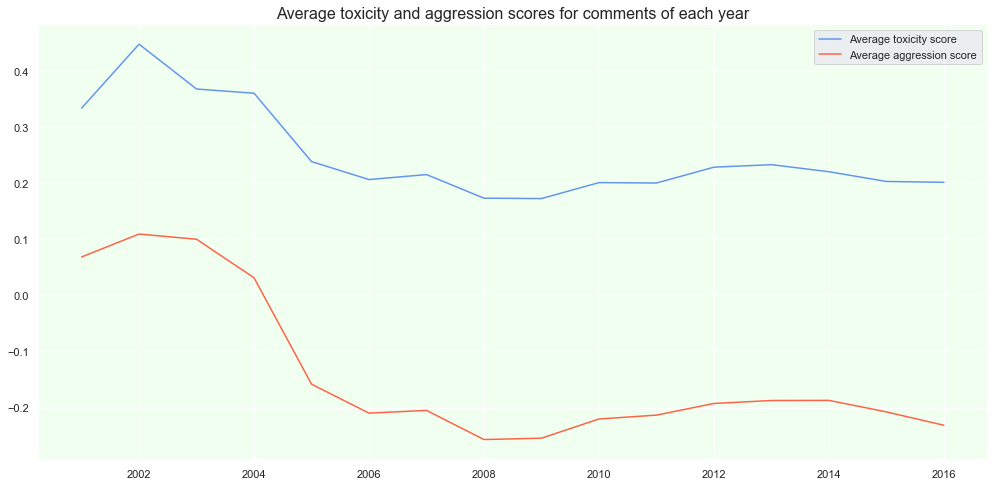

In [206]:
groups_of_years_toxicity_reviews = toxicity_join[['rev_id','year','avg_toxicity_score']].drop_duplicates().groupby('year')
groups_of_years_aggression_reviews = aggression_join[['rev_id','year','avg_aggression_score']].drop_duplicates().groupby('year')
avg_toxicity_scores = pd.DataFrame(groups_of_years_toxicity_reviews['avg_toxicity_score'].mean().rename(
    "Average toxicity score")).reset_index()
avg_aggression_scores = pd.DataFrame(groups_of_years_aggression_reviews['avg_aggression_score'].mean().rename(
    "Average aggression score")).reset_index()

fig, ax = plt.subplots(1, 1)
ax.plot(avg_toxicity_scores.year, avg_toxicity_scores['Average toxicity score'], color="cornflowerblue", label='Average toxicity score', linestyle="-")
ax.plot(avg_aggression_scores.year, avg_aggression_scores['Average aggression score'], color="tomato", label='Average aggression score', linestyle="-")
ax.legend()
ax.set_facecolor('honeydew')
fig.set_figheight(8)
fig.set_figwidth(17)
plt.title("Average toxicity and aggression scores for comments of each year", fontsize=16)
plt.savefig("Average_toxicity_aggression_rating_by_age_over_time.png")
plt.show()

There is a clear trend of increasing toxicity and aggression in the first half of the naughts. It then appears to have roughly stabilized for the remainder of the study window.

Now let's check for differences between the different age cohorts and between males and females. Here we create a plot of the average male reviewer toxicity scores for each year in the dataset, for each of the age groups:

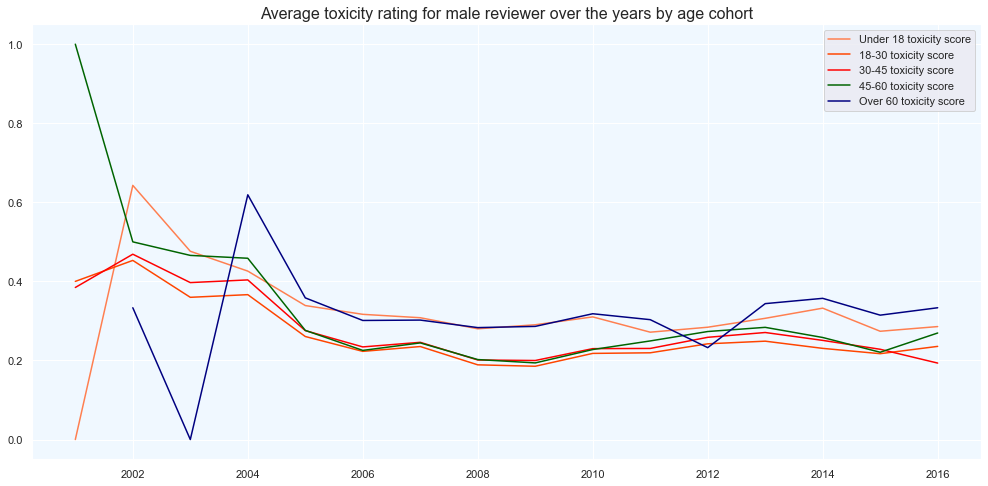

In [207]:
# group the toxicity join table by age and then year and take the average in each of these groups:
male_toxicity_join = toxicity_join[toxicity_join.gender == 'male']
male_age_group_average_toxicity_over_years = pd.DataFrame(male_toxicity_join.groupby(['age_group','year']).toxicity_score.mean()).reset_index()

#now take the timeseries of each of the age groups
under_eighteen_toxicity_series = male_age_group_average_toxicity_over_years[male_age_group_average_toxicity_over_years.age_group == 'Under 18']
eighteen_to_thirty_toxicity_series = male_age_group_average_toxicity_over_years[male_age_group_average_toxicity_over_years.age_group == '18-30']
thirty_to_fourty_five_toxicity_series = male_age_group_average_toxicity_over_years[male_age_group_average_toxicity_over_years.age_group == '30-45']
fourty_five_to_sixty_toxicity_series = male_age_group_average_toxicity_over_years[male_age_group_average_toxicity_over_years.age_group == '45-60']
over_sixty_toxicity_series = male_age_group_average_toxicity_over_years[male_age_group_average_toxicity_over_years.age_group == 'Over 60']

# plot
fig, ax = plt.subplots(1, 1)
ax.plot(under_eighteen_toxicity_series.year, under_eighteen_toxicity_series['toxicity_score'], color="coral", label='Under 18 toxicity score', linestyle="-")
ax.plot(eighteen_to_thirty_toxicity_series.year, eighteen_to_thirty_toxicity_series['toxicity_score'], color="orangered", label='18-30 toxicity score', linestyle="-")
ax.plot(thirty_to_fourty_five_toxicity_series.year, thirty_to_fourty_five_toxicity_series['toxicity_score'], color="red", label='30-45 toxicity score', linestyle="-")
ax.plot(fourty_five_to_sixty_toxicity_series.year, fourty_five_to_sixty_toxicity_series['toxicity_score'], color="darkgreen", label='45-60 toxicity score', linestyle="-")
ax.plot(over_sixty_toxicity_series.year, over_sixty_toxicity_series['toxicity_score'], color="navy", label='Over 60 toxicity score', linestyle="-")
ax.legend()
ax.set_facecolor('aliceblue')
plt.title("Average toxicity rating for male reviewer over the years by age cohort", fontsize=16)
fig.set_figheight(8)
fig.set_figwidth(17)
plt.savefig("Average_male_toxicity_rating_by_age_over_time.png")
plt.show()

Now the same for the female toxicity reviewers:

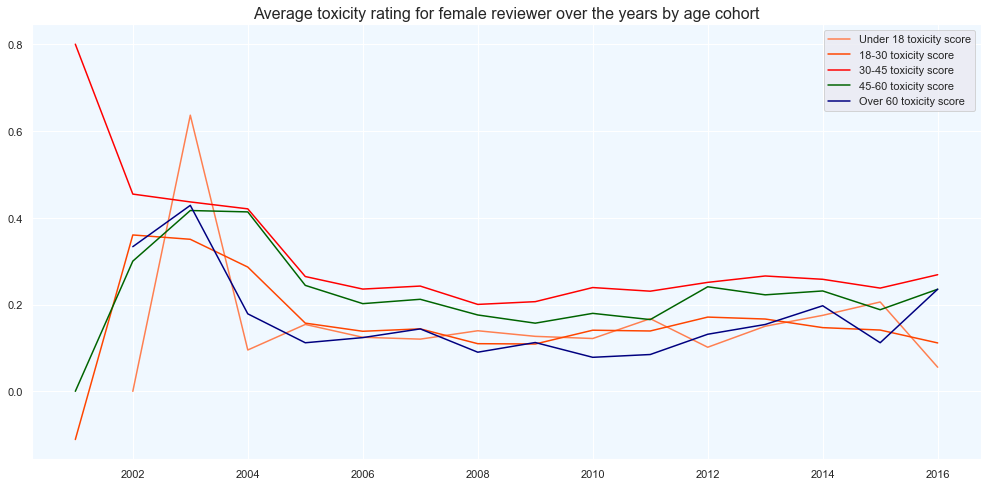

In [208]:
# group the toxicity join table by age and then year and take the average in each of these groups:
female_toxicity_join = toxicity_join[toxicity_join.gender == 'female']
female_age_group_average_toxicity_over_years = pd.DataFrame(female_toxicity_join.groupby(['age_group','year']).toxicity_score.mean()).reset_index()

#now take the timeseries of each of the age groups
under_eighteen_toxicity_series = female_age_group_average_toxicity_over_years[female_age_group_average_toxicity_over_years.age_group == 'Under 18']
eighteen_to_thirty_toxicity_series = female_age_group_average_toxicity_over_years[female_age_group_average_toxicity_over_years.age_group == '18-30']
thirty_to_fourty_five_toxicity_series = female_age_group_average_toxicity_over_years[female_age_group_average_toxicity_over_years.age_group == '30-45']
fourty_five_to_sixty_toxicity_series = female_age_group_average_toxicity_over_years[female_age_group_average_toxicity_over_years.age_group == '45-60']
over_sixty_toxicity_series = female_age_group_average_toxicity_over_years[female_age_group_average_toxicity_over_years.age_group == 'Over 60']

# plot
fig, ax = plt.subplots(1, 1)
ax.plot(under_eighteen_toxicity_series.year, under_eighteen_toxicity_series['toxicity_score'], color="coral", label='Under 18 toxicity score', linestyle="-")
ax.plot(eighteen_to_thirty_toxicity_series.year, eighteen_to_thirty_toxicity_series['toxicity_score'], color="orangered", label='18-30 toxicity score', linestyle="-")
ax.plot(thirty_to_fourty_five_toxicity_series.year, thirty_to_fourty_five_toxicity_series['toxicity_score'], color="red", label='30-45 toxicity score', linestyle="-")
ax.plot(fourty_five_to_sixty_toxicity_series.year, fourty_five_to_sixty_toxicity_series['toxicity_score'], color="darkgreen", label='45-60 toxicity score', linestyle="-")
ax.plot(over_sixty_toxicity_series.year, over_sixty_toxicity_series['toxicity_score'], color="navy", label='Over 60 toxicity score', linestyle="-")
ax.legend()
ax.set_facecolor('aliceblue')
plt.title("Average toxicity rating for female reviewer over the years by age cohort", fontsize=16)
fig.set_figheight(8)
fig.set_figwidth(17)
plt.savefig("Average_female_toxicity_rating_by_age_over_time.png")
plt.show()

This is interesting. While the older cohort (age 45+) in the set of female reviewers seem to be the most likely to rate comments as toxic, this trend does not hold out for males. Also, it seems clear that the toxicity of comments steadily increased from the beginning of the period we have data until sometime in the mid naughts where it has seemed to flatline (with a good amount of variance over the years.) Also, the female reviewers seem to have much more variance across age groups compared to males, with what appears to be a rough trend being the older they were at review time the more toxic they viewed the average comment. This trend does not appear to hold out for the males, although the male cohort that viewed the comments as most toxic was the over 60 group. The males that viewed comments as least toxic seemed to be those between 30 and 60, though as said the deviation across groups is much smaller for the males.

Let's create the same plots, but for average aggression reviews over the years.

And now we do the same thing but for the aggression reviews:

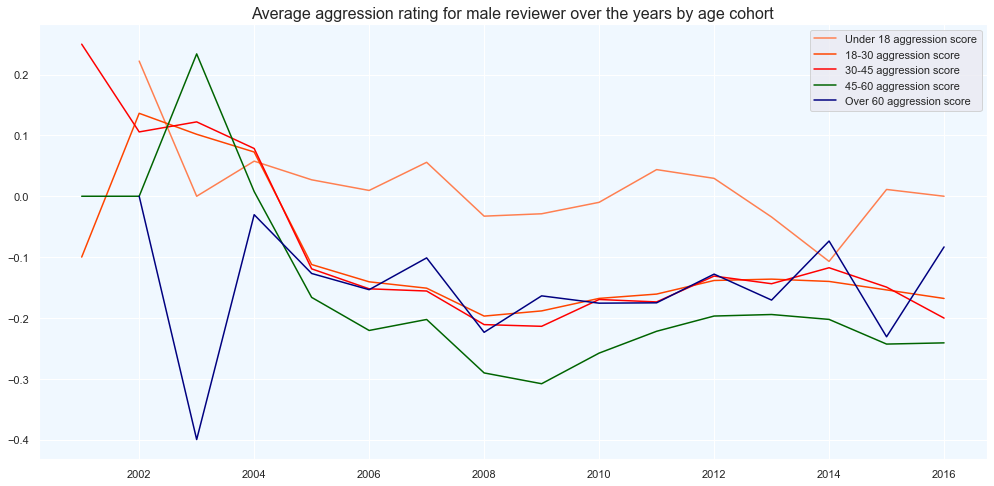

In [209]:
# group the aggression join table by age and then year and take the average in each of these groups:
male_aggression_join = aggression_join[aggression_join.gender == 'male']
male_age_group_average_aggression_over_years = pd.DataFrame(
    male_aggression_join.groupby(['age_group','year']).aggression_score.mean()).reset_index()

#now take the timeseries of each of the age groups
under_eighteen_aggression_series = male_age_group_average_aggression_over_years[male_age_group_average_aggression_over_years.age_group == 'Under 18']
eighteen_to_thirty_aggression_series = male_age_group_average_aggression_over_years[male_age_group_average_aggression_over_years.age_group == '18-30']
thirty_to_fourty_five_aggression_series = male_age_group_average_aggression_over_years[male_age_group_average_aggression_over_years.age_group == '30-45']
fourty_five_to_sixty_aggression_series = male_age_group_average_aggression_over_years[male_age_group_average_aggression_over_years.age_group == '45-60']
over_sixty_aggression_series = male_age_group_average_aggression_over_years[male_age_group_average_aggression_over_years.age_group == 'Over 60']

# plot
fig, ax = plt.subplots(1, 1)
ax.plot(under_eighteen_aggression_series.year, under_eighteen_aggression_series['aggression_score'], color="coral", label='Under 18 aggression score', linestyle="-")
ax.plot(eighteen_to_thirty_aggression_series.year, eighteen_to_thirty_aggression_series['aggression_score'], color="orangered", label='18-30 aggression score', linestyle="-")
ax.plot(thirty_to_fourty_five_aggression_series.year, thirty_to_fourty_five_aggression_series['aggression_score'], color="red", label='30-45 aggression score', linestyle="-")
ax.plot(fourty_five_to_sixty_aggression_series.year, fourty_five_to_sixty_aggression_series['aggression_score'], color="darkgreen", label='45-60 aggression score', linestyle="-")
ax.plot(over_sixty_aggression_series.year, over_sixty_aggression_series['aggression_score'], color="navy", label='Over 60 aggression score', linestyle="-")
ax.legend()
ax.set_facecolor('aliceblue')
plt.title("Average aggression rating for male reviewer over the years by age cohort", fontsize=16)
fig.set_figheight(8)
fig.set_figwidth(17)
plt.savefig("Average_male_aggression_rating_by_age_over_time.png")
plt.show()

And now let's create a plot for the female agression reviewers:

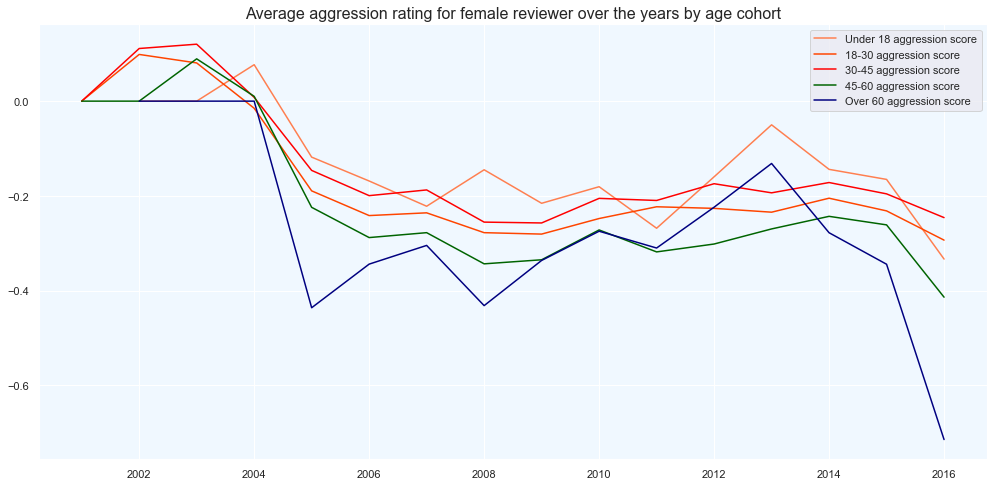

In [210]:
# group the aggression join table by age and then year and take the average in each of these groups:
female_aggression_join = aggression_join[aggression_join.gender == 'female']
female_age_group_average_aggression_over_years = pd.DataFrame(
    female_aggression_join.groupby(['age_group','year']).aggression_score.mean()).reset_index()

#now take the timeseries of each of the age groups
under_eighteen_aggression_series = female_age_group_average_aggression_over_years[female_age_group_average_aggression_over_years.age_group == 'Under 18']
eighteen_to_thirty_aggression_series = female_age_group_average_aggression_over_years[female_age_group_average_aggression_over_years.age_group == '18-30']
thirty_to_fourty_five_aggression_series = female_age_group_average_aggression_over_years[female_age_group_average_aggression_over_years.age_group == '30-45']
fourty_five_to_sixty_aggression_series = female_age_group_average_aggression_over_years[female_age_group_average_aggression_over_years.age_group == '45-60']
over_sixty_aggression_series = female_age_group_average_aggression_over_years[female_age_group_average_aggression_over_years.age_group == 'Over 60']

# plot
fig, ax = plt.subplots(1, 1)
ax.plot(under_eighteen_aggression_series.year, under_eighteen_aggression_series['aggression_score'], color="coral", label='Under 18 aggression score', linestyle="-")
ax.plot(eighteen_to_thirty_aggression_series.year, eighteen_to_thirty_aggression_series['aggression_score'], color="orangered", label='18-30 aggression score', linestyle="-")
ax.plot(thirty_to_fourty_five_aggression_series.year, thirty_to_fourty_five_aggression_series['aggression_score'], color="red", label='30-45 aggression score', linestyle="-")
ax.plot(fourty_five_to_sixty_aggression_series.year, fourty_five_to_sixty_aggression_series['aggression_score'], color="darkgreen", label='45-60 aggression score', linestyle="-")
ax.plot(over_sixty_aggression_series.year, over_sixty_aggression_series['aggression_score'], color="navy", label='Over 60 aggression score', linestyle="-")
ax.legend()
ax.set_facecolor('aliceblue')
plt.title("Average aggression rating for female reviewer over the years by age cohort", fontsize=16)
fig.set_figheight(8)
fig.set_figwidth(17)
plt.savefig("Average_female_aggression_rating_by_age_over_time.png")
plt.show()

# Implications for research and product development
Below are some questions relating to the application of tools built on top of this dataset, such as the Perspective API. 

### What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why?
Based on my analysis, toxicity and aggression review scores are sensitive to both gender and age group so the effectiveness of this dataset for end users will depend on how closely their demographics resemble those of the reviewers. For instance, if classifiers to detect hate speech were built and deployed to sites which are primarily trafficked by older women, a group that seems to have particular sensitivity to aggression and toxicity and is very underrepresented in this dataset, the classifiers would likely allow through many comments that would offend this audience. However if they were deployed to sites which are primarily trafficked by young men they might prove very useful.

### What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?
The representation of the various cohorts in this dataset has a fairly significant effect on which comments are considered toxic and aggressive. Had the reviewer gender breakdown been closer to the approximately 50/50 split in the population at large (in actually, women account for more than half of the US population), some comments which were rated toxic and aggressive would not have been and even more still which weren't evaluated as toxic/aggressive would have been. In cases such as the Comment Filter this could mean that some comments that the majority of actual users found innocuous could wind up censored, and conversely some comments that users find unpleasant would be let through. Whether or not that is tolerable depends entirely on the downstream consequences of such censorship or exposure to toxicity/aggressiveness and is thus context and end user dependent.

### Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?
If I was tasked with addressing these biases I would preprocess the datasets before training classifiers to try and mitigate some of the effects of the non representative sample. The example above of doubling the female reviews is one simple example. Another more sophisticated approach might be to try and learn the conditional distribution of each sparse cohort's review tendency given reviews of the more frequently appearing cohorts, and use that to similate data for these cohorts on comments that weren't reviewed by them. These scores could then be included in the training set for a downstream classifier.